In [1]:
import os
import numpy as np
import cv2
import pathlib
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import utils
import calibration_utils

import importlib
importlib.reload(utils)
importlib.reload(calibration_utils)

<module 'calibration_utils' from 'c:\\Users\\citak\\Desktop\\KITTI_Sensor_Fusion\\lidar_based_obstacle_detection\\calibration_utils.py'>

## Dataset Reading

In [3]:
###############################
## Document Path Definition ##
###############################

kitti_main_path = r'C:\KITTI'

kitti_point_clouds_path = os.path.join(kitti_main_path, 'point_clouds')
kitti_point_clouds_training_path = os.path.join(kitti_point_clouds_path, 'training')
kitti_point_clouds_testing_path = os.path.join(kitti_point_clouds_path, 'testing')

kitti_images_path = os.path.join(kitti_main_path, 'left_color_images')
kitti_images_training_path = os.path.join(kitti_images_path, 'training')
kitti_images_testing_path = os.path.join(kitti_images_path, 'testing')

kitti_labels_path = os.path.join(kitti_main_path, 'training_labels')
kitti_labelss_training_path = os.path.join(kitti_labels_path, 'training')

kitti_calibration_path = os.path.join(kitti_main_path, 'data_object_calib')
kitti_calibration_training_path = os.path.join(kitti_calibration_path, 'training')

In [4]:
kitti_images_training = os.listdir(kitti_images_training_path)
kitti_images_training = [os.path.join(kitti_images_training_path, elem) for elem in kitti_images_training]

kitti_images_testing = os.listdir(kitti_images_testing_path)
kitti_images_testing = [os.path.join(kitti_images_testing_path, elem) for elem in kitti_images_testing]

print("# of training and testing images: {} / {}".format(len(kitti_images_training), len(kitti_images_testing)))

# of training and testing images: 7481 / 7518


In [5]:
kitti_training_labels = os.listdir(kitti_labelss_training_path)
kitti_training_labels_paths = [os.path.join(kitti_labelss_training_path, label_file) for label_file in kitti_training_labels]


print("# of training files: {}".format(len(kitti_training_labels)))

example_label_file = utils.parse_label_file(kitti_training_labels_paths[0])
print(example_label_file)

# of training files: 7481
[{'Type': 'Pedestrian', 'Truncated': 0.0, 'Occluded': 0, 'Alpha': -0.2, 'BBox_xmin': 712.4, 'BBox_ymin': 143.0, 'BBox_xmax': 810.73, 'BBox_ymax': 307.92, 'Dimensions_height': 1.89, 'Dimensions_width': 0.48, 'Dimensions_length': 1.2, 'Location_x': 1.84, 'Location_y': 1.47, 'Location_z': 8.41, 'RotationY': 0.01}]


In [6]:
point_cloud_files_training = os.listdir(kitti_point_clouds_training_path)
print("# cloud files: {}".format(len(point_cloud_files_training)))

print('--> File Names')
print(point_cloud_files_training[:3])

# cloud files: 7481
--> File Names
['000000.bin', '000001.bin', '000002.bin']


In [7]:
kitti_training_calibrations = os.listdir(kitti_calibration_training_path)
kitti_training_calibrations_paths = [os.path.join(kitti_calibration_training_path, calib_file) for calib_file in kitti_training_calibrations]


print("# of training calibration files: {}".format(len(kitti_training_calibrations_paths)))


print(kitti_training_calibrations_paths[0])

example_calib_file = utils.parse_calib_file(kitti_training_calibrations_paths[0])
print(example_calib_file)

# of training calibration files: 7481
C:\KITTI\data_object_calib\training\000000.txt
{'P0': array([[707.0493,   0.    , 604.0814,   0.    ],
       [  0.    , 707.0493, 180.5066,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]], dtype=float32), 'P1': array([[ 707.0493,    0.    ,  604.0814, -379.7842],
       [   0.    ,  707.0493,  180.5066,    0.    ],
       [   0.    ,    0.    ,    1.    ,    0.    ]], dtype=float32), 'P2': array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02,  4.575831e+01],
       [ 0.000000e+00,  7.070493e+02,  1.805066e+02, -3.454157e-01],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  4.981016e-03]],
      dtype=float32), 'P3': array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02, -3.341081e+02],
       [ 0.000000e+00,  7.070493e+02,  1.805066e+02,  2.330660e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  3.201153e-03]],
      dtype=float32), 'R0': array([[ 0.9999128 ,  0.01009263, -0.00851193],
       [-0.01012729,  0.9999406 , -0

## A sample analysis

### 1. Load Data

The Calib. Data
{'P0': array([[707.0493,   0.    , 604.0814,   0.    ],
       [  0.    , 707.0493, 180.5066,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]], dtype=float32), 'P1': array([[ 707.0493,    0.    ,  604.0814, -379.7842],
       [   0.    ,  707.0493,  180.5066,    0.    ],
       [   0.    ,    0.    ,    1.    ,    0.    ]], dtype=float32), 'P2': array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02,  4.575831e+01],
       [ 0.000000e+00,  7.070493e+02,  1.805066e+02, -3.454157e-01],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  4.981016e-03]],
      dtype=float32), 'P3': array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02, -3.341081e+02],
       [ 0.000000e+00,  7.070493e+02,  1.805066e+02,  2.330660e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  3.201153e-03]],
      dtype=float32), 'R0': array([[ 0.9999128 ,  0.01009263, -0.00851193],
       [-0.01012729,  0.9999406 , -0.00403767],
       [ 0.00847067,  0.00412352,  0.9999556 ]], dtype=fl

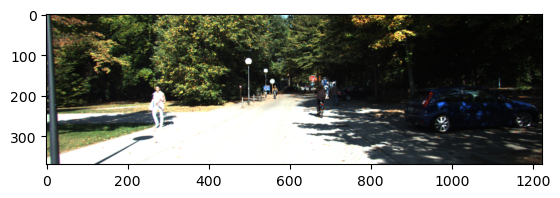

In [8]:
analysis_file_index = 5902

################
#### Calib Label
################
sample_calib = utils.parse_calib_file(kitti_training_calibrations_paths[analysis_file_index])
print('The Calib. Data')
print(sample_calib)


###############
#### G.T. Label
###############
sample_label = utils.parse_label_file(kitti_training_labels_paths[analysis_file_index])
print('The G.T. Objects and Their Meta Data')
print(sample_label)

###############
#### Image Side
###############

sample_image_path = kitti_images_training[analysis_file_index]
print("Sample Image Path: {}\n".format(sample_image_path))
sample_image = cv2.imread(sample_image_path)[:,:,::-1]

plt.imshow(sample_image);

In [9]:
###############
#### Lidar Side
###############

# a sample bin file reading and visualization
sample_bin_file_path = os.path.join(kitti_point_clouds_training_path, point_cloud_files_training[analysis_file_index])
print("Sample Cloud File Path: {}\n".format(sample_bin_file_path))

sample_pcd = utils.read_velodyne_bin(sample_bin_file_path)

# show the contents of .bin file
print('--> .bin File Content\n')
print(sample_pcd[:3])

Sample Cloud File Path: C:\KITTI\point_clouds\training\005902.bin

--> .bin File Content

[[77.704  0.169  2.837  0.   ]
 [78.408  1.649  2.861  0.   ]
 [77.905  4.089  2.847  0.   ]]


In [10]:
print('Min/Max values for all dimensions')
print((np.min(sample_pcd[:,0]), np.max(sample_pcd[:,0])), (np.min(sample_pcd[:,1]), np.max(sample_pcd[:,1])), (np.min(sample_pcd[:,2]), np.max(sample_pcd[:,2])))

Min/Max values for all dimensions
(-79.723, 79.346) (-63.079, 45.413) (-2.505, 2.861)


In [11]:
# Convert the NumPy array to Open3D PointCloud
sample_point_cloud = o3d.geometry.PointCloud()
sample_point_cloud.points = o3d.utility.Vector3dVector(sample_pcd[:, :3])  # Use only x, y, z coordinates
o3d.visualization.draw_geometries([sample_point_cloud], width=1600, height=900)

### 2. Voxel downsampling

In [12]:
print(f"Points before downsampling: {len(sample_point_cloud.points)} ")
sample_point_cloud = sample_point_cloud.voxel_down_sample(voxel_size=0.2)
print(f"Points after downsampling: {len(sample_point_cloud.points)}")
o3d.visualization.draw_geometries([sample_point_cloud], width=1600, height=900)

Points before downsampling: 122794 
Points after downsampling: 33122


### 3. RANSAC Segmentation to identify the largest plane (in this case the ground/road) from objects above it

In [13]:
plane_model, inliers = sample_point_cloud.segment_plane(distance_threshold=0.3, ransac_n=3, num_iterations=150)

## Identify inlier points -> road
inlier_cloud = sample_point_cloud.select_by_index(inliers)
inlier_cloud.paint_uniform_color([0, 1, 1])

## Identify outlier points -> objects on the road
outlier_cloud = sample_point_cloud.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([1, 0, 0])

## visualize the components
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud], width=1600, height=900)

### 4. Clustering using DBSCAN -> To further segment objects on the road

In [14]:
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(outlier_cloud.cluster_dbscan(eps=0.45, min_points=10, print_progress=True))

print(labels, len(list(set(labels))))

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 183
[ -1  -1 174 ...  -1  20  20] 184


In [15]:
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")

## Get label colors
colors = plt.get_cmap("tab20")(labels/(max_label if max_label>0 else 1))
colors[labels<0] = 0

## Colorized objects on the road
outlier_cloud.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([outlier_cloud], width=1600, height=900)

point cloud has 183 clusters


### 5. Generate 3D Bounding Boxes


In [23]:
obbs = []
indexes = pd.Series(range(len(labels))).groupby(labels, sort=False).apply(list).tolist()

MAX_POINTS = 300
MIN_POINTS = 25

## For each individual object on the road
for i in range(0, len(indexes)):
    nb_points = len(outlier_cloud.select_by_index(indexes[i]).points)
    # If object size within the criteria, draw bounding box
    if (nb_points>MIN_POINTS and nb_points<MAX_POINTS):
        sub_cloud = outlier_cloud.select_by_index(indexes[i])
        obb = sub_cloud.get_axis_aligned_bounding_box()
        obb.color = (1, 0, 0) # R, G, B
        obbs.append(obb)

print(f"Number of Bounding Boxes calculated {len(obbs)}")

Number of Bounding Boxes calculated 67


### 6. Combined all visuals: outlier_cloud (objects), obbs (oriented bounding boxes), inlier_cloud (road)

In [24]:
list_of_visuals = []
list_of_visuals.append(outlier_cloud)
list_of_visuals.extend(obbs)
list_of_visuals.append(inlier_cloud)

print(type(sample_point_cloud))
print(type(list_of_visuals))
o3d.visualization.draw_geometries(list_of_visuals, width=1600, height=900)

<class 'open3d.cpu.pybind.geometry.PointCloud'>
<class 'list'>


### 7. Evaluate the Predicted Bounding Boxes v G.T. Bounding Boxes

In [25]:
print("# of predicted bounding box: {}".format(len(obbs)))
restructured_pred_bboxes = []

for predicted_bbox in obbs:
    box_min_bound = predicted_bbox.min_bound
    box_max_bound = predicted_bbox.max_bound

    min_corner = (predicted_bbox.min_bound[0], predicted_bbox.min_bound[1], predicted_bbox.min_bound[2])
    max_corner = (predicted_bbox.max_bound[0], predicted_bbox.max_bound[1], predicted_bbox.max_bound[2])

    restructured_pred_bboxes.append({"min": min_corner, "max": max_corner})


print(restructured_pred_bboxes[:5])

# of predicted bounding box: 67
[{'min': (29.87150001525879, 5.168000221252441, -1.3495000004768372), 'max': (32.582000732421875, 7.263999938964844, 1.3250000476837158)}, {'min': (-0.017000000923871994, -17.988000869750977, -0.48100000619888306), 'max': (3.4199999570846558, -15.520999908447266, 0.8069999814033508)}, {'min': (23.757999420166016, 17.111000061035156, -0.7715000212192535), 'max': (25.244500160217285, 18.702999114990234, 1.0420000553131104)}, {'min': (-8.032999992370605, -23.74000015258789, -0.3189999908208847), 'max': (-4.297666708628337, -23.21500015258789, 1.0549999475479126)}, {'min': (-31.2189998626709, 17.70599937438965, -1.6660000085830688), 'max': (-30.84000015258789, 21.104000091552734, 1.4459999799728394)}]


In [26]:
Tr_velo_to_cam = sample_calib['Tr_velo_to_cam'] # 3x4 matrix
Tr_velo_to_cam = np.vstack((Tr_velo_to_cam, [0, 0, 0, 1]))  # Convert to 4x4, homogenous coordinate system
Tr_cam_to_velo = calibration_utils.inverse_rigid_trans(Tr_velo_to_cam)

restructured_gt_bboxes = []

for gt_element in sample_label:

    # Compute 3D Bounding Box and project it from camera plane to Velodyne coord. system 
    box3d_pts_3d_velo = calibration_utils.compute_box_3d(gt_element, Tr_cam_to_velo)

    # Convert points to Open3D PointCloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(box3d_pts_3d_velo)

    # Compute AxisAlignedBoundingBox
    aabb = pcd.get_axis_aligned_bounding_box()

    # Set the color of G.T. Bounding Box
    aabb.color = (0, 1, 0)  # Green color


    restructured_gt_bboxes.append(aabb)


print(restructured_gt_bboxes)

[AxisAlignedBoundingBox: min: (11.1414, 4.97208, -1.58158), max: (12.0483, 5.62372, 0.131201), AxisAlignedBoundingBox: min: (14.3085, -1.67552, -1.54447), max: (16.0141, -1.08012, 0.269073), AxisAlignedBoundingBox: min: (8.94196, -7.5428, -1.25428), max: (10.5796, -3.74815, 0.0679794), AxisAlignedBoundingBox: min: (35.243, 2.01382, -1.30869), max: (36.9693, 2.69987, 0.425121), AxisAlignedBoundingBox: min: (21.7584, -3.4039, -1.45692), max: (22.649, -2.85477, 0.365519), AxisAlignedBoundingBox: min: (27.5434, -8.5312, -1.23865), max: (29.1886, -4.10236, 0.185387)]


In [27]:
list_of_visuals_gt = []
list_of_visuals_gt.append(outlier_cloud)
list_of_visuals_gt.extend(restructured_gt_bboxes)
list_of_visuals_gt.append(inlier_cloud)
o3d.visualization.draw_geometries(list_of_visuals_gt, width=1600, height=900)

In [28]:
results = utils.evaluate_metrics(restructured_gt_bboxes, obbs, iou_threshold=0.2)
results

{'TP': 3, 'FP': 64, 'FN': 3}